# Exercice 2 - Re identification

In this exercice, we will train and evaluate the Siamese network on the Market-1501 database. the dataset is composed of crop arround persons. It contains 32668 images of 1501 persons, split into train/test sets of 12936/19732 images.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---

## Q1 - Plot sample images of the Martket-1501 database  

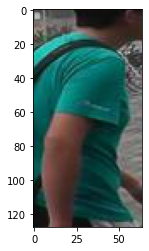

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/drive/MyDrive/Colab Notebooks/ROB313/exercice2/data/Market-1501-v15.09.15/bounding_box_test/0000_c1s1_019176_02.jpg')
plt.imshow(img)
plt.show()
plt.close()



---


## Q2 - Triplet loss 

The code of triplet loss on ./utils/TripletLoss.py is as folloe :

```python
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
        margin (float): margin for triplet.
    """

    def __init__(self, margin=0.3, mutual_flag=False):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (numclasses)
        """
        n = inputs.size(0)

        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss
```



---


## Q3 - Explain RandomSampler.py

Customize the sampling methode. Randomly sample batchid type of samples. And each type sample has batchimage number of samples.





---


## Q4 - Complete the class Market1501

Comlete the code as follow in the class Market1501 on ./data.py. It can load the dataset.

```python
def __getitem__(self, index):
    # please write the __getitem__ method
    data_path = self.imgs[index]
    image = Image.open(data_path)
    id = self.get_id(data_path)
    target = self._id2label[id]
    img = self.transform(image)

    return img, target
```



---


## Q5 - Complet the DNN 

Complete the code as follow on ./network.py. Resnet 50 is used. And the last layer is deleted and replaced by 2 fully connected layers.

```python
class REID_NET(nn.Module):
    def __init__(self):
        # write the CNN initialization
        super(REID_NET, self).__init__()

        self.fc_hidden1=1024
        self.fc_hidden2=768
        self.resnet = resnet50(pretrained=True)
        self.inchannel = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(nn.Linear(self.inchannel, self.fc_hidden1),
                                       nn.ReLU(),
                                       nn.Linear(self.fc_hidden1, self.fc_hidden2))
        self.fc_id = nn.Linear(self.fc_hidden2, num_classes)
        self.fc_metric = nn.Linear(self.fc_hidden2, num_classes)

    def forward(self, x):
        # write the CNN forward
        x = self.resnet(x)  # ResNet

        predict_id= self.fc_id(x) # Write this layer
        predict_metric= self.fc_metric(x) # Write this layer

        predict = torch.cat([predict_id, predict_metric], dim=1)

        return predict, predict_id, predict_metric
```

The code of loss function as follow. The loss fuction is sum of triplet loss function and cresentropy loss function. The auxialiary loss can improve the training. The euqatiion as follow :

$Loss = TripletLoss + 2*CrossEntropy$

```python
class Loss(loss._Loss):
    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, outputs, labels):
        cross_entropy_loss = CrossEntropyLoss()
        triplet_loss = TripletLoss(margin=1.2)

        Triplet_Loss = triplet_loss(outputs[1], labels)
        #Triplet_Loss = sum(Triplet_Loss) / len(Triplet_Loss)

        CrossEntropy_Loss = cross_entropy_loss(outputs[2], labels)
        #CrossEntropy_Loss = sum(CrossEntropy_Loss) / len(CrossEntropy_Loss)

        loss_sum = Triplet_Loss + 2 * CrossEntropy_Loss

        print('\rtotal loss:%.2f  Triplet_Loss:%.2f  CrossEntropy_Loss:%.2f' % (
            loss_sum.data.cpu().numpy(),
            Triplet_Loss.data.cpu().numpy(),
            CrossEntropy_Loss.data.cpu().numpy()),
              end=' ')
        return loss_sum
```



---


## Q6-Q7 - Train and Evaluate the model

The code de model training sa follow :

```python
def train(model,train_loader,scheduler,optimizer,loss_function):

    # PLEASE COMPLETE THE TRAINING FUNCTION
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        output = model(inputs.to('cuda'))
        loss = loss_function(output, labels.to('cuda'))
        optimizer.zero_grad() # set 0 for gradient
        loss.backward()
        optimizer.step()
    scheduler.step()
```

The process of training and evaluating as follow. 

In [ ]:
import os

path = "/content/drive/MyDrive/Colab Notebooks/ROB313/exercice2"
os.chdir(path)
os.listdir(path)

!python main.py

Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
   train  | 751 |  12936  |  6
  ----------------------------------------
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
   test  | 751 |  15913  |  6
  ----------------------------------------
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
   query  | 750 |  3368  |  6
  ----------------------------------------

epoch 1
/content/drive/MyDrive/Colab Notebooks/ROB313/exercice2/utils/TripletLoss.py:55: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered inter